# Single-phase flow

In this tutorial we investigate how to solve single-phase flow in PorePy. <br>
We consider
* two-point flux approximation
* multi-point flux approximation
* dual virtual element method

**Note**: This tutorial will focus on a 2d domain, however most of the code works for 1d, 2d, and 3d domains.<br>

Let is $\Omega$ a regular domain with boundary $\partial \Omega$. The boundary can be divided in two non-overlapping parts useful to impose Dirichlet ($\partial \Omega_d$) and Neumann ($\partial \Omega_n$) boundary conditions. We indicate with $\mathbf{n}$ the outward unit normal vector of $\partial \Omega$.<br>
The single-phase flow can be written in
* dual formulation as:
$$\nabla \cdot \mathbf{u} = f \qquad \mathbf{u} = - K \nabla p$$
with boundary conditions on $\partial \Omega_d$ and $\partial \Omega_n$:
$$ p = p_b \qquad \mathbf{u} \cdot \mathbf{n} = u_b$$
* primal formulation as:
$$ - \nabla \cdot K \nabla p = f $$
with boundary conditions on $\partial \Omega_d$ and $\partial \Omega_n$:
$$ p = p_b \qquad - K \nabla p \cdot \mathbf{n} = u_b$$

Where $f$ is a scalar source/sink term, $K$ is the permeability matrix, $p_b$ is the pressure at the boundary (Dirichlet condition), and $u_p$ is the flux at the boundary (Neumann condition).<br>

We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem. <br><br>

For the example we assume: $\Omega$ as presented below, $\partial \Omega_d = \partial \Omega$, $\partial \Omega_n = \emptyset$, with data: $f = 1$, $K = I$, and $p_b = 0$.

## Import basic modules

Before creating the grid we import NumPy, the SciPy sparse library and PorePy.

In [1]:
import numpy as np
import scipy.sparse as sps
import porepy as pp

## Creation of the grid

We create first a Cartesian grid.

In [2]:
Nx = Ny = 20                                          
g = pp.CartGrid([Nx, Ny], [2, 2])

We manipulate the grid and then compute its geometrical quantities.

In [3]:
g.nodes[0, :] = g.nodes[0, :] - 1
g.nodes[1, :] = g.nodes[1, :] - 1

def dist(n): return np.dot(pp.cg.rot(np.linalg.norm(n), [0, 0, 1]), n)
g.nodes = np.apply_along_axis(dist, 0, g.nodes)

g.compute_geometry()

We plot the grid using the interface with matplotlib.

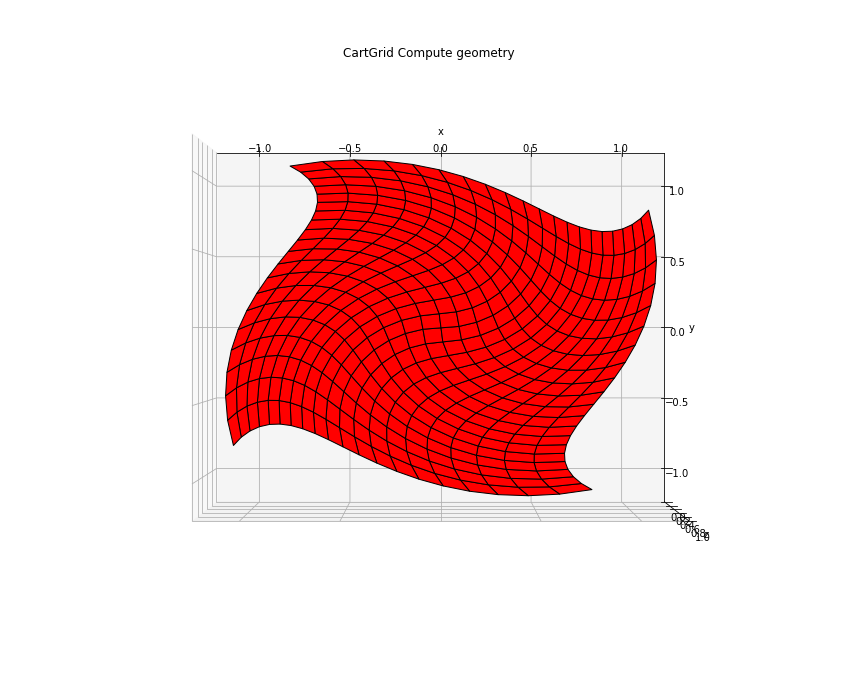

In [4]:
pp.plot_grid(g, figsize=(15, 12))

# Define the problem data

We declare the permeability matrix $K$, the scalar source term $f$, and the boundary conditions

In [5]:
# Permeability
perm = pp.SecondOrderTensor(g.dim, np.ones(g.num_cells))                     

# Unitary scalar source already integrated in each cell
f = g.cell_volumes

# Boundary conditions
b_faces = g.tags['domain_boundary_faces'].nonzero()[0]
bc = pp.BoundaryCondition(g, b_faces, ['dir']*b_faces.size)
bc_val = np.zeros(g.num_faces)

Once all the data are created we group them in a dictionary, where the keyword `"flow"` represent the physical process considered and ensures that the discretization objects use the correct parameters. Note that the call to initialize_data assignes default values to the flow parameters which are not specified. This means that we could have omitted the specification of `"bc_values"` and `"permeability"`, since we have assigned the default values for these.

In [6]:
specified_parameters = {"permeability": perm, "source": f, "bc": bc, "bc_values": bc_val}
data = pp.initialize_data({}, g, "flow", specified_parameters)

## Problem solution

In this section we present all the approaches to solve the problem.<br>
**Note**: The problem data are not stored in the solver class.

### Two-point flux approximation

The two-point flux approximation solves the single-phase flow problem in the primal formulation. We use this to discretize the flux term, before assembling it. The source term is discretized using the FV Integral class. Note that if no previous discretization exists, calling `assemble_matrix_rhs()` triggers a call to the `discretize()` method. The pressure is directly computed.

In [7]:
solver_flow = pp.Tpfa("flow")
A, b_flow = solver_flow.assemble_matrix_rhs(g, data)

solver_rhs = pp.Integral("flow")
_, b_rhs = solver_rhs.assemble_matrix_rhs(g, data)

p = sps.linalg.spsolve(A, b_flow+b_rhs) 

To represent the solution.

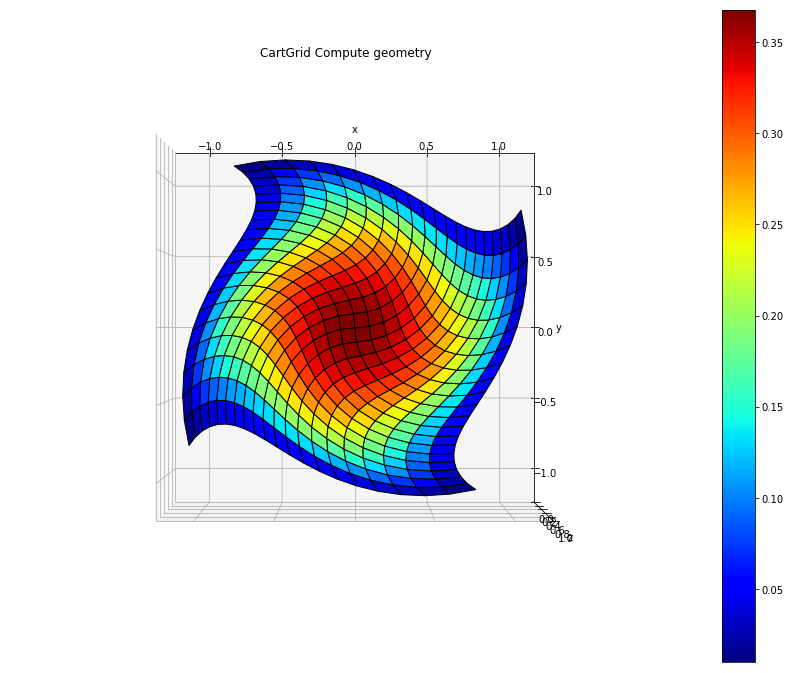

In [8]:
pp.plot_grid(g, p, figsize=(15, 12))

Consistency check:

In [9]:
assert np.isclose(np.sum(p), 76.019359625426816)

### Multi-point flux approximation 

The multi-point flux approximation solves the single-phase flow problem in the primal formulation. We discretize the flux term anew with the MPFA, and assemble the matrix. Note that we have to explicitly call the 'discretize' method, as there is already a (TPFA) discretization of the flux term stored in 'data'. We reuse the source term discretization, as this is the same for TPFA and MPFA.

In [10]:
solver_flow = pp.Mpfa("flow")
solver_flow.discretize(g, data)
A, b_flow = solver_flow.assemble_matrix_rhs(g, data)

p = sps.linalg.spsolve(A, b_flow+b_rhs)

To represent the solution:

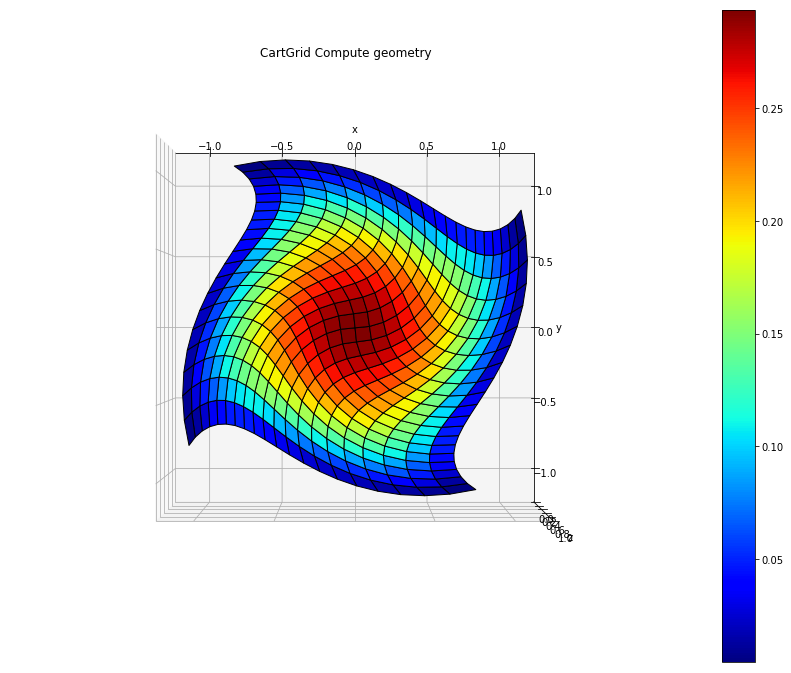

In [11]:
pp.plot_grid(g, p, figsize=(15, 12))

Consistency check:

In [12]:
assert np.isclose(np.sum(p), 56.40038615835368)

56.40038615835368


### Dual virtual element method

The dual virtual element method solves the single-phase flow problem in the dual formulation. The pressure and the normal flux to each face are directly computed.

In [13]:
solver_flow = pp.MVEM("flow")
solver_flow.discretize(g, data)
A, b_flow = solver_flow.assemble_matrix_rhs(g, data)

solver_rhs = pp.DualIntegral("flow")
_, b_rhs = solver_rhs.assemble_matrix_rhs(g, data)

up = sps.linalg.spsolve(A, b_flow+b_rhs)                                              

# Extract the normal flux and pressure from the solution
u = solver_flow.extract_flux(g, up)
p = solver_flow.extract_pressure(g, up) 

# For visualisation purpose project the flux on a vector piecewise constant field
P0u = solver_flow.project_flux(g, u, data)

To represent the pressure and velocity solution:

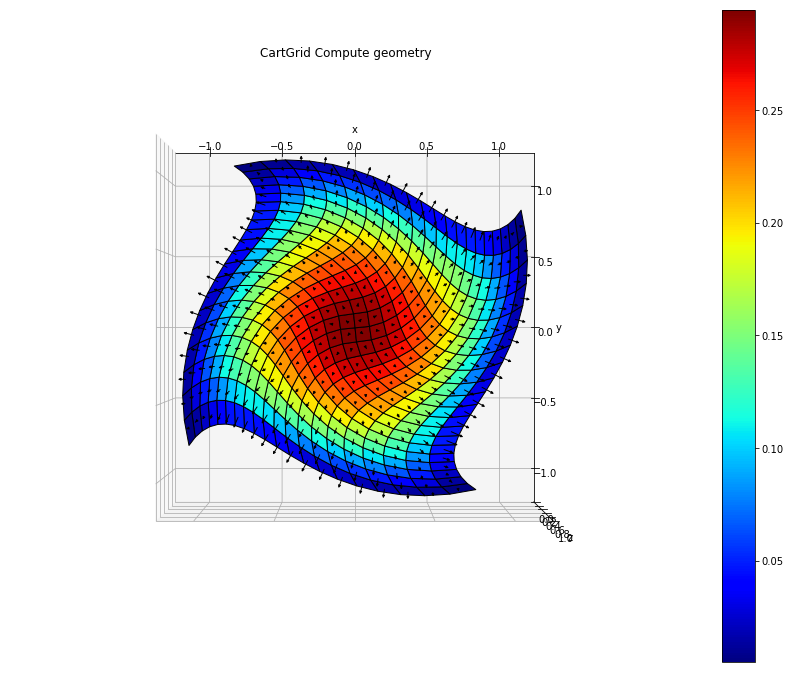

In [14]:
pp.plot_grid(g, p, P0u * 0.2, figsize=(15, 12))

Consistency check:

In [15]:
assert np.isclose(np.sum(p), 56.939552128161012)
assert np.isclose(np.sum(u), 0)
assert np.isclose(np.sum(P0u), 0)